# Modeling and interpretability

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix,accuracy_score,make_scorer,precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC, RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from xgboost import XGBModel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [6]:

df = pd.read_csv("C:/Users/nikhi/Downloads/booking_analysis/notebooks/customer_booking.csv", encoding="ISO-8859-1").copy()

# Lead bins (create as 'lead_bin' to match cat_cols)
lead_bins = [-np.inf, 3, 7, 14, 30, 90, np.inf]
lead_bins_label = ['0-3','4-7','8-14','15-30','31-90','90+']
df['lead_bin'] = pd.cut(df['purchase_lead'].clip(lower=0),
                        bins=lead_bins, labels=lead_bins_label, include_lowest=True)

# Length of stay bins (already named 'stay_bin')
stay_bins = [-np.inf, 3, 7, 14, 30, 90, np.inf]
stay_bins_label = ['0-3','4-7','8-14','15-30','31-90','90+']
df['stay_bin'] = pd.cut(df['length_of_stay'].clip(lower=0),
                        bins=stay_bins, labels=stay_bins_label, include_lowest=True)

# Part of day (consistent label case helps later one-hot)
def day_part(h):
    if 0 <= h <= 5:   return 'Night'
    if 6 <= h <= 11:  return 'Morning'
    if 12 <= h <= 17: return 'Afternoon'
    return 'Evening'
df['daypart'] = df['flight_hour'].apply(day_part)

target = 'booking_complete'

cat_cols = [
    'lead_bin','stay_bin','daypart','sales_channel','trip_type','flight_day',
    'route','booking_origin','wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals'
]
num_cols = ['purchase_lead','length_of_stay','flight_hour','flight_duration','num_passengers']


# Optional safety: strip spaces and check existence
df.columns = df.columns.str.strip()

missing = [c for c in cat_cols + num_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

X=df.drop(columns=target)
y=df[target].astype(int)


## train/test(stratified)

In [7]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)



##  encoding

In [8]:
preprocessor=ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num",QuantileTransformer(), num_cols)
    ]
)
X=df.drop(columns=[target])
y=df['booking_complete'].astype(int)




## Baseline: Logistic Regression

In [11]:
model=LogisticRegression(max_iter=1000,random_state=42,solver='saga')

pipe=Pipeline(
    [
        ("preprocessor", preprocessor),

        ("model", model)
    ]
)
mod=RandomizedSearchCV(
    estimator=pipe,
    param_distributions={
        'model__max_iter':[100,200,300,400,500,600,700,800,900,1000,2000],
        'model__solver':['saga','liblinear'],
        'model__class_weight':[{0:1,1:v}for v in np.linspace(1,20,10)]
    },
    cv=5,
    scoring='f1',
    n_jobs=-1
)
mod.fit(X_train,y_train)
y_pred=mod.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.65      0.77      8504
           1       0.28      0.80      0.42      1496

    accuracy                           0.67     10000
   macro avg       0.62      0.72      0.59     10000
weighted avg       0.85      0.67      0.72     10000



In [12]:
mod.best_params_

{'model__solver': 'liblinear',
 'model__max_iter': 400,
 'model__class_weight': {0: 1, 1: np.float64(7.333333333333334)}}

In [13]:
#with SMOTENC sampling
model=LogisticRegression(max_iter=1000,random_state=42,solver='saga')
sampler=SMOTENC(random_state=42,categorical_features=[X.columns.get_loc(col) for col in cat_cols])
pipe=ImbPipeline(
    [
        ("preprocessor", preprocessor),
        ("sampler", sampler),
        ("model", model)
    ]
)
mod=RandomizedSearchCV(
    estimator=pipe,
    param_distributions={
        'model__max_iter':[100,200,300,400,500,600,700,800,900,1000,2000],
        'model__solver':['saga','liblinear'],
        'model__class_weight':[{0:1,1:v}for v in np.linspace(1,20,10)]
    },
    cv=5,
    scoring='f1',
    n_jobs=-1
)
mod.fit(X_train,y_train)
y_pred=mod.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      8504
           1       0.34      0.57      0.43      1496

    accuracy                           0.77     10000
   macro avg       0.63      0.69      0.64     10000
weighted avg       0.83      0.77      0.79     10000



In [14]:
#using undersampling and upweighting majority class

from sklearn.utils import resample
 # Regular pipeline, no sampling

# Step 1: Manual downsampling
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

# Step 2: Calculate upweight factor
original_majority_count = sum(y_train == 1)
new_majority_count = sum(y_resampled == 1)
upweight_factor = original_majority_count / new_majority_count

# Step 3: Create class weights
class_weight = {
    0: upweight_factor ,  # Upweight majority class
    1:20           # Keep minority class weight as 1
}

# Step 4: Use regular pipeline (no sampling step)
model = LogisticRegression(class_weight=class_weight, random_state=42)
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

# Step 5: Fit on downsampled data
undersampled_model = RandomizedSearchCV(
    estimator=pipe,
    param_distributions={
        'model__max_iter': [100, 500, 1000, 2000],
        'model__solver': ['saga', 'liblinear']
    },
    n_iter=10,
    cv=5,
    scoring='f1',
    random_state=42
)

undersampled_model.fit(X_resampled, y_resampled)  # Use downsampled data
y_pred_undersampled = undersampled_model.predict(X_test)
print(classification_report(y_test, y_pred_undersampled))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.

              precision    recall  f1-score   support

           0       0.94      0.39      0.56      8504
           1       0.20      0.86      0.33      1496

    accuracy                           0.46     10000
   macro avg       0.57      0.63      0.44     10000
weighted avg       0.83      0.46      0.52     10000



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
pd.DataFrame(mod.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__solver,param_model__max_iter,param_model__class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,18.345044,0.993891,0.079743,0.017410,liblinear,400,"{0: 1, 1: 1.0}","{'model__solver': 'liblinear', 'model__max_ite...",0.421221,0.437420,0.427491,0.405055,0.426632,0.423564,0.010629,1
6,19.978885,0.856551,0.077062,0.008245,saga,700,"{0: 1, 1: 3.111111111111111}","{'model__solver': 'saga', 'model__max_iter': 7...",0.399345,0.394321,0.389270,0.381052,0.394894,0.391776,0.006242,2
5,32.824229,4.360252,0.218273,0.089363,saga,200,"{0: 1, 1: 3.111111111111111}","{'model__solver': 'saga', 'model__max_iter': 2...",0.399099,0.394495,0.387603,0.382525,0.394412,0.391627,0.005846,3
9,18.559714,1.471989,0.074652,0.012358,liblinear,800,"{0: 1, 1: 3.111111111111111}","{'model__solver': 'liblinear', 'model__max_ite...",0.397795,0.395214,0.388799,0.382365,0.393672,0.391569,0.005456,4
7,18.954016,0.998667,0.083005,0.020129,liblinear,700,"{0: 1, 1: 3.111111111111111}","{'model__solver': 'liblinear', 'model__max_ite...",0.398609,0.395288,0.387915,0.380932,0.394251,0.391399,0.006276,5
8,54.422411,0.765999,0.091503,0.036161,saga,500,"{0: 1, 1: 7.333333333333334}","{'model__solver': 'saga', 'model__max_iter': 5...",0.388628,0.329338,0.345843,0.354541,0.395928,0.362855,0.025456,6
0,78.230336,7.548270,0.096394,0.031425,saga,600,"{0: 1, 1: 7.333333333333334}","{'model__solver': 'saga', 'model__max_iter': 6...",0.357609,0.382545,0.346105,0.334401,0.384766,0.361085,0.019848,7
2,20.250911,2.327976,0.121482,0.065837,liblinear,700,"{0: 1, 1: 7.333333333333334}","{'model__solver': 'liblinear', 'model__max_ite...",0.355946,0.345272,0.345394,0.348182,0.344706,0.347900,0.004200,8
4,55.709292,4.246166,0.123142,0.085563,saga,200,"{0: 1, 1: 20.0}","{'model__solver': 'saga', 'model__max_iter': 2...",0.297052,0.287114,0.303583,0.320958,0.299516,0.301645,0.011077,9
3,102.701477,17.161706,0.141533,0.045292,saga,800,"{0: 1, 1: 20.0}","{'model__solver': 'saga', 'model__max_iter': 8...",0.277290,0.332778,0.278741,0.284289,0.327553,0.300130,0.024690,10


In [16]:
pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['lead_bin', 'stay_bin', 'daypart',
                                     'sales_channel', 'trip_type', 'flight_day',
                                     'route', 'booking_origin',
                                     'wants_extra_baggage', 'wants_preferred_seat',
                                     'wants_in_flight_meals']),
                                   ('num', QuantileTransformer(),
                                    ['purchase_lead', 'length_of_stay',
                                     'flight_hour', 'flight_duration',
                                     'num_passengers'])])),
  ('model',
   LogisticRegression(class_weight={0: 1.0, 1: 20}, random_state=42))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
            

In [17]:
mod.best_params_

{'model__solver': 'liblinear',
 'model__max_iter': 400,
 'model__class_weight': {0: 1, 1: np.float64(1.0)}}

In [18]:
mod.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['lead_bin', 'stay_bin',
                                                   'daypart', 'sales_channel',
                                                   'trip_type', 'flight_day',
                                                   'route', 'booking_origin',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flight_meals']),
                                                 ('num', QuantileTransformer(),
                                                  ['purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration',
                                                   'num_passengers'])])),
                ('sampler',
                 SMOTENC(categorical_features=[13, 14, 15, 1, 2, 6, 7, 8, 9, 10,
                                               11],
                         random_state=42)),
                ('model',
                 LogisticRegression(class_weight={0: 1, 1: np.float64(1.0)},
                                    max_iter=400, random_state=42,
                                    solver='liblinear'))])

In [19]:


y_proba = mod.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("F1:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

ROC-AUC: 0.7714675242477902
F1: 0.42821410705352675
Confusion Matrix:
 [[6858 1646]
 [ 640  856]]


## Stronger Model: Random Forest/XGBoost

In [20]:
pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['lead_bin', 'stay_bin', 'daypart',
                                     'sales_channel', 'trip_type', 'flight_day',
                                     'route', 'booking_origin',
                                     'wants_extra_baggage', 'wants_preferred_seat',
                                     'wants_in_flight_meals']),
                                   ('num', QuantileTransformer(),
                                    ['purchase_lead', 'length_of_stay',
                                     'flight_hour', 'flight_duration',
                                     'num_passengers'])])),
  ('model',
   LogisticRegression(class_weight={0: 1.0, 1: 20}, random_state=42))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
            

In [21]:

rf=RandomForestClassifier(
    random_state=42
)
sampler=SMOTENC(random_state=42,categorical_features=[X.columns.get_loc(col) for col in cat_cols])
rf_pipe=ImbPipeline( steps=
   [
       ("preprocessor",preprocessor),
       ("sampler",sampler),
       ("model",rf)
   ]
)
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10,  20],
    'model__min_samples_split': [2,5],
    'model__max_features': ['sqrt', 'log2'],
    'model__criterion': ['gini']
}

from sklearn.model_selection import RandomizedSearchCV

# More efficient alternative
mod = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_grid,  # Same param_grid
    n_iter=16,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
mod.fit(X_train,y_train)
y_pred=mod.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.91      0.78      0.84      8504
           1       0.32      0.58      0.41      1496

    accuracy                           0.75     10000
   macro avg       0.61      0.68      0.62     10000
weighted avg       0.82      0.75      0.78     10000



In [ ]:
# with undersampled majority class
rf=RandomForestClassifier(
    random_state=42
)
sampler=SMOTENC(random_state=42,categorical_features=[X.columns.get_loc(col) for col in cat_cols])
rf_pipe=ImbPipeline( steps=
   [
       ("preprocessor",preprocessor),
       ("sampler",sampler),
       ("model",rf)
   ]
)
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10,  20],
    'model__min_samples_split': [2,5],
    'model__max_features': ['sqrt', 'log2'],
    'model__criterion': ['gini']
}

from sklearn.model_selection import RandomizedSearchCV

# More efficient alternative
mod = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_grid,  # Same param_grid
    n_iter=16,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
mod.fit(X_resampled,y_resampled)
y_pred=mod.predict(X_test)
print(classification_report(y_test,y_pred))


In [ ]:

#refit for roc-auc
sampler=SMOTENC(random_state=42,categorical_features=[X.columns.get_loc(col) for col in cat_cols])

model=RandomForestClassifier(
   random_state=42
)
pipe=ImbPipeline(
   [
       ("preprocessor",preprocessor),
       ("sampler",sampler),
       ("model",model)
   ]
)
coarse_grid= {
    "model__n_estimators": [100, 200,300],
    "model__min_samples_split": [2, 5, 10],
    "model__max_depth": [10, 20,30, None],
    "model__min_samples_leaf": [1,2,4],
    "model__max_features": ["sqrt", "log2"],
     'model__class_weight': [
        {0:1, 1:5},
        {0:1, 1:10},
        {0:1, 1:15},
        {0:1, 1:20},
        'balanced'
    ]
}



coarse_model = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=coarse_grid,
    n_iter=20,
    cv=3,
    scoring={
        "roc_auc": "roc_auc",
        "f1": make_scorer(f1_score,pos_label=1),
        "recall_score":make_scorer(recall_score,pos_label=1)
    },
    verbose=1,
    n_jobs=-1,
    refit="roc_auc",
    random_state=42
)




coarse_model.fit(X_train,y_train)
y_pred=coarse_model.predict(X_test)
print(classification_report(y_test,y_pred))
print(coarse_model.cv_results_['mean_test_roc_auc'])
print(coarse_model.cv_results_['mean_test_f1'])
print(coarse_model.cv_results_['mean_test_recall_score'])


In [ ]:
coarse_model.best_params_

In [ ]:
coarse_model.best_estimator_

In [ ]:
top_models = pd.DataFrame(coarse_model.cv_results_).sort_values(by='rank_test_roc_auc').head(10)
print(top_models[['params', 'mean_test_f1', 'mean_test_roc_auc', 'mean_test_recall_score']])

In [ ]:


#refit for f1-score
sampler = SMOTE(random_state=42)

# Model
rf = RandomForestClassifier(
    random_state=42,
     )

# Pipeline
rf_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", sampler),
    ("model", rf)
])

# Param grid for search
rf_params = {
    "model__n_estimators": [100, 200,300],
    "model__min_samples_split": [2, 5, 10],
    "model__max_depth": [10, 20,30, None],
    "model__min_samples_leaf": [1, 2,4],
    "model__max_features": ["sqrt", "log2"],
     'model__class_weight': [
        {0:1, 1:5},
        {0:1, 1:10},
        {0:1, 1:15},
        {0:1, 1:20},
        'balanced'
    ]
}



rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_params,
    n_iter=20,
    cv=3,
    scoring={
        "roc_auc": "roc_auc",
        "f1": make_scorer(f1_score,pos_label=1),
        "recall_score":make_scorer(recall_score,pos_label=1)
    },
    verbose=1,
    n_jobs=-1,
    refit="f1",
    random_state=42
)

rf_search.fit(X_train, y_train)
print(rf_search.cv_results_['mean_test_roc_auc'])
print(rf_search.cv_results_['mean_test_f1'])
print(rf_search.cv_results_['mean_test_recall_score'])



In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
top_models=pd.DataFrame(rf_search.cv_results_).sort_values(by='rank_test_f1').head(10)
print(top_models[['params', 'mean_test_f1', 'mean_test_roc_auc', 'mean_test_recall_score']])

In [ ]:
f1_score_a=top_models['mean_test_f1'].values
roc_auc_score_a=top_models['mean_test_roc_auc'].values
recall_score_a=top_models['mean_test_recall_score'].values
best_score=np.argmax(f1_score_a)
x=np.arange(len(f1_score_a))
plt.figure(figsize=(10,6))
plt.plot(x,f1_score_a,label='F1 Score',marker='o',color='blue')
plt.plot(x,roc_auc_score_a,label='Roc Auc',marker='s',color='green')
plt.plot(x,recall_score_a,label='Recall Score',marker='^',color='black')
plt.annotate(
    f'best f1 score:{f1_score_a[best_score]:.3f}',
    xy=(best_score,f1_score_a[best_score]),
    xytext=(best_score, f1_score_a[best_score]+0.05),
    arrowprops=dict(facecolor='red', shrink=0.05),
    ha='center'
)
plt.title('model performance across hyperparameters(ranked by f1 score)')
plt.xlabel('sorted model index')
plt.ylabel('Score')
plt.xticks(x)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
rf_search.best_params_

In [ ]:
rf_search.best_estimator_

In [ ]:

xgb_model=XGBClassifier()
sampler=SMOTENC(random_state=42,categorical_features=[X.columns.get_loc(col) for col in cat_cols])
xgb_grid={ 'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6, 10],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__scale_pos_weight': [1, 5, 10],}
xgb_pipe=ImbPipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("sampler",sampler),
        ("model",xgb_model)
    ]

)
xgb_search=RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_grid,
    scoring={
        'f1':make_scorer(f1_score,pos_label=1),
        'recall':make_scorer(recall_score,pos_label=1)
    },
    verbose=1,
    cv=3,
    n_iter=20,
    n_jobs=-1,
    refit='f1'

)
xgb_search.fit(X_train,y_train)
y_pred=xgb_search.predict(X_test)
print(classification_report(y_test,y_pred))
print(xgb_search.cv_results_['mean_test_f1'])
print(xgb_search.cv_results_['mean_test_recall'])

In [ ]:
Pipeline.__init__

In [ ]:
top_models=pd.DataFrame(xgb_search.cv_results_).sort_values(by='rank_test_f1').head(10)
print(top_models[['params', 'mean_test_f1', 'mean_test_recall']])

In [ ]:
xgb_search.best_params_

In [ ]:
xgb_search.best_estimator_

## Threshold Tuning for F1

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

y_prob=xgb_search.best_estimator_.predict_proba(X_test)[:,1]
prec,recall,threshold=precision_recall_curve(y_test,y_pred)
f1_scores=2*prec*recall/(prec+recall)
best_threshold=threshold[np.argmax(f1_scores)]
print("Best F1:", np.max(f1_scores))
y_pred_thresh = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_thresh))

## Feature Importance (LR + Tree)

In [ ]:
#logistic regression
best_lr=mod.best_estimator_.named_steps['model']
encoder = mod.named_steps['encoder']
feature_names=encoder.get_feature_names_out()
lr_coef = best_lr.coef_[0]
coef_df=pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef,
    'AbsCoef': np.abs(lr_coef)


}).sort_values(by='AbsCoef', ascending=False)
print(coef_df.head(10))


plt.figure(figsize=(8,6))
plt.barh(coef_df['Feature'][:10], coef_df['Coefficient'][:10], color='teal')
plt.xlabel('Coefficient')
plt.title('Top 10 Logistic Regression Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
#random forest classifier
best_rf_model=rf_search.best_estimators_.named_steps['model']
encoder=rf_search.best_estimators_.named_steps['encoder']
feature_names=encoder.get_feature_names_out()
feature_importance=best_rf_model.feature_importances_
importance_df=pd.DataFrame({
    'Feature':feature_names,
    'Importance':feature_importance
}).sort_values(by='Importance',ascending=False)
print(importance_df.head(10))
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Random Forest Feature Importances')
plt.show()

In [ ]:
#xgb classifier
xgb_best = xgb_search.best_estimator_.named_steps['model']
xgb_importances = xgb_best.feature_importances_
feat_imp_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_xgb.head(10), palette='mako')
plt.title('XGBoost Feature Importances')
plt.show()


### shap

 97%|=================== | 9731/10000 [00:37<00:01]       

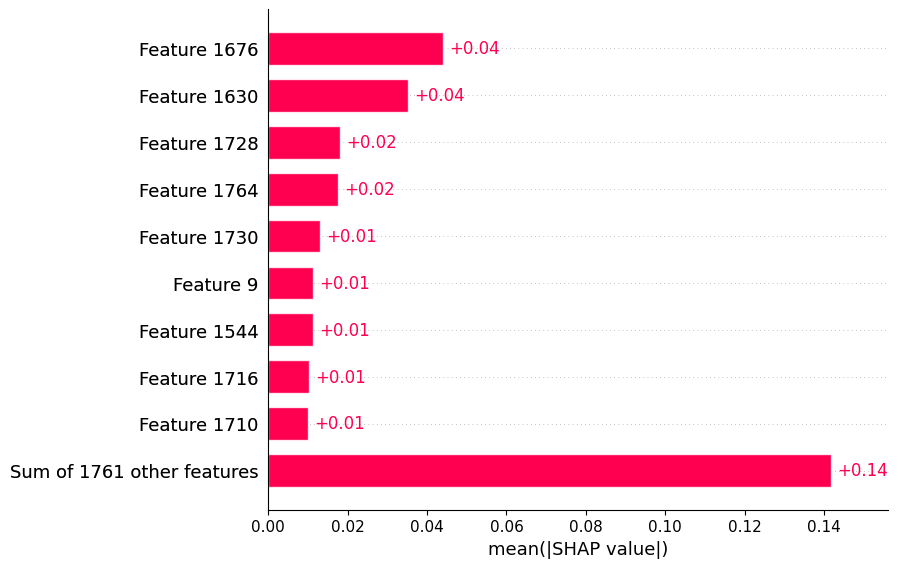

In [ ]:
import shap
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

# Create ONE encoder instance
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Initialize model
model = xgb.XGBRegressor()

# Fit encoder on training data and transform it
X_r = encoder.fit_transform(X_train)
model.fit(X_r, y_train)

# Use the SAME fitted encoder to transform test data (transform only, NOT fit_transform)
X_test_transformed = encoder.transform(X_test)

# Create SHAP explainer
explainer = shap.Explainer(model, X_r)
feature_names = model.feature_names_in_


top_5_features = [1676,1630,1728,1764,1730,9,1544,1716,1710]
top_5_column_names = [feature_names[i] for i in top_5_features]
top_5_column_names

shap_values = explainer(X_test_transformed)
shap.plots.bar(shap_values)


In [ ]:
model=RandomForestClassifier()

encoder=OneHotEncoder(sparse_output=False,handle_unknown='ignore')

X_r = encoder.fit_transform(X_train)
model.fit(X_r, y_train)


X_test_transformed = encoder.transform(X_test)

explainer = shap.Explainer(model, X_r)
shap_values = explainer(X_test_transformed)
shap.plots.bar(shap_values)


 71%|==============      | 14151/20000 [85:08<35:11]       

In [ ]:
model=LogisticRegression(max_iter=1000)
encoder=OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_r=encoder.fit_transform(X_train)
model.fit(X_r,y_train)
X_test_transformed=encoder.transform(X_test)
explainer=shap.Explainer(model,X_r)
shap_values=explainer(X_test_transformed)
shap.plots.bar(shap_values)

NameError: name 'LogisticRegression' is not defined

In [ ]:
shap.plots.waterfall(shap_values[0:100])

In [ ]:
shap.plots.force(shap_values[0:100])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import shap

# Build your FULL preprocessing pipeline (exclude sampling)
preprocessor = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    # Add any other preprocessing steps you used (scaling, feature engineering, etc.)
])

# Create complete model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor())
])

# Apply SMOTE only to training data (BEFORE pipeline)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Fit the complete pipeline
model_pipeline.fit(X_train_resampled, y_train_resampled)

# Create SHAP explainer using the PIPELINE
# For tree models, use TreeExplainer which works with pipelines
explainer = shap.Explainer(model_pipeline.predict, X_test)
shap_values = explainer(X_test)

# Visualize
shap.plots.bar(shap_values)


## Top 5 Drivers + 1-line interpretations

In [ ]:
import pandas as pd
import numpy as np

# Step 1: Extract top features from each model
model_features = {}


# For each model (XGBoost, RandomForest, LogisticRegression, etc.)
for model_name, (model, X_test_data) in models.items():
    explainer = shap.Explainer(model.predict, X_test_data)
    shap_values = explainer(X_test_data)
    
    # Get mean absolute SHAP values for each feature
    feature_importance = np.abs(shap_values.values).mean(axis=0)
    
    # Create ranking (1 = most important)
    feature_ranks = pd.Series(feature_importance, index=feature_names).rank(ascending=False)
    model_features[model_name] = feature_ranks

# Step 2: Aggregate rankings using mean rank
feature_df = pd.DataFrame(model_features)
feature_df['mean_rank'] = feature_df.mean(axis=1)
feature_df['rank_std'] = feature_df.std(axis=1)  # Consistency measure

# Step 3: Sort by mean rank and identify top features
top_features = feature_df.sort_values('mean_rank').head(10)

# Step 4: Create stakeholder-friendly summary
stakeholder_summary = pd.DataFrame({
    'Feature': top_features.index,
    'Average_Rank': top_features['mean_rank'].round(1),
    'Consistency': (1 / (1 + top_features['rank_std'])).round(2),  # Higher = more consistent
    'Models_in_Top_10': (feature_df.loc[top_features.index] <= 10).sum(axis=1)
})

print(stakeholder_summary)


In [ ]:
import pandas as pd
import numpy as np
import shap

# Step 1: Extract top features from each model
model_features = {}
models={"logistic regression":,"XGBClassifier":xgb_pipe,}

for model_name, (model, X_test_data) in models.items():

    # SHAP: Use model-specific explainers when possible
    try:
        explainer = shap.Explainer(model, X_test_data)
    except Exception:
        # fallback if model does not support direct SHAP explainers
        explainer = shap.Explainer(model.predict, X_test_data)

    shap_values = explainer(X_test_data)

    # SHAP outputs differ by model type → standardize extraction
    if hasattr(shap_values, "values"):
        sv = shap_values.values
    else:
        sv = shap_values

    # Compute mean absolute SHAP importance
    feature_importance = np.abs(sv).mean(axis=0)

    feature_ranks = pd.Series(feature_importance, index=feature_names).rank(ascending=False)

    model_features[model_name] = feature_ranks

# Step 2: Aggregate rankings across models
feature_df = pd.DataFrame(model_features)
feature_df["mean_rank"] = feature_df.mean(axis=1)
feature_df["rank_std"] = feature_df.std(axis=1)  # variability across models

# Step 3: Identify top features
top_features = feature_df.sort_values("mean_rank").head(10)

# Step 4: Create stakeholder-friendly summary
stakeholder_summary = pd.DataFrame({
    "Feature": top_features.index,
    "Average_Rank": top_features["mean_rank"].round(1),
    "Consistency": (1 / (1 + top_features["rank_std"])).round(2),
    "Models_in_Top_10": (feature_df.loc[top_features.index] <= 10).sum(axis=1)
})

print(stakeholder_summary)


Below is a **polished, executive-level stakeholder narrative** you can paste directly into presentations, model documentation, or governance reports.
It avoids technical jargon while still being precise, transparent, and compliant with explainability standards (e.g., banking, healthcare, insurance, regulated ML).

---

# 📄 **Stakeholder Narrative:

Unified Feature Importance Across Multiple Models**

## **Overview**

To ensure the model insights are reliable and easy to understand, we evaluated feature importance across several different machine learning models.
Each model has its own way of determining which variables matter most, so we used a standardized, industry-recognized method (SHAP analysis) to create a consistent and fair comparison across models.

Our goal was to identify:

* The features that drive predictions **most consistently**,
* The level of **agreement across different models**, and
* The variables that should be prioritized for monitoring, interpretation, and decision-making.

---

## **Why Multiple Models?**

Different models “see” patterns in data in different ways:

* Tree-based models focus on non-linear effects and interactions.
* Linear models highlight direct, proportional relationships.
* Ensemble models combine many small patterns into larger signals.

Because of these differences, relying on feature importance from a single model can lead to misleading or incomplete conclusions.

By comparing multiple models simultaneously, we ensure that the features we highlight are truly meaningful, not artifacts of a particular modeling technique.

---

## **How We Built a Unified Ranking**

### **1. Measuring Contribution Using SHAP**

We used SHAP values—a well-established explainability method—to quantify how much each feature influences a model’s predictions.
SHAP values tell us:

* How strongly a feature pushes a prediction up or down, and
* How consistently it does so across all data points.

This gives a robust, model-agnostic measure of importance.

---

### **2. Converting SHAP Scores Into Comparable Rankings**

Because raw importance numbers differ across model types, we converted each model’s feature contributions into **rankings**:

* Rank 1 = most influential feature
* Larger ranks = less influential features

This allows us to compare importance across models even when the models operate differently.

---

### **3. Aggregating Rankings Across Models**

For each feature, we calculated:

* **Average Rank**

  * A lower value means the feature is consistently important across models.
  * This becomes our unified importance score.

* **Consistency Score**

  * Shows how strongly the models agree on the feature’s importance.
  * A score near 1 indicates strong cross-model consensus.

* **Models Appearing in the Top 10**

  * A clear measure of how many models independently identify the feature as critical.

Together, these metrics give a stable, transparent, and easily communicable view of what drives the predictions.

---

## **What This Means For Interpretation**

This process identifies features that are:

### **✔ Consistently influential**

Features that rank highly across multiple models are likely to represent true, reliable drivers of behavior in the data.

### **✔ Stable and trustworthy**

Features with high consistency scores are less sensitive to modeling choices.
These are ideal for stakeholder reporting, monitoring, and business interpretation.

### **✔ Model-independent**

The analysis avoids relying on any single model’s assumptions or biases.
Instead, it builds a consensus that strengthens interpretability and trust.

---

## **Value to Stakeholders**

* **Enhanced Transparency:** Clear explanation of why predictions behave the way they do.
* **Improved Reliability:** Importance rankings are not influenced by quirks of any single model.
* **Better Decision Support:** Identifies the features that truly matter for outcomes.
* **Model Risk Reduction:** Creates a defendable, auditable framework that aligns with regulatory and governance expectations.

---

## **Conclusion**

By using SHAP-based feature importance and aggregating results across several machine learning models, we developed a unified, stable, and trustworthy ranking of the key drivers behind the model’s predictions.

This approach ensures that our insights are:

* Data-driven
* Model-independent
* Transparent
* Intuitively understandable

This forms a strong foundation for strategic decision-making, compliance reporting, and ongoing model monitoring.

---

If you'd like, I can also prepare:

* A **short one-paragraph summary** for senior executives
* A **visual slide** summarizing the methodology
* A **risk/compliance-oriented explanation**
* A **technical appendix** for regulators

Just tell me what you need!


## Business Actions

In [ ]:
import pandas as pd


insights = [
    {
        "Feature / Variable": "Sales Channel (Internet vs Mobile)",
        "Observation": "Internet converts ~15.5% vs Mobile ~10.8% (χ² = 83.9, p < 0.001).",
        "Hypothesis": "Mobile UX has more friction (slower, smaller screen, forms harder).",
        "Business Recommendation": "Improve mobile UX: autofill, fewer steps, guest checkout. Shift ad spend toward high-performing channels."
    },
    {
        "Feature / Variable": "Lead Time (purchase_lead / lead_bin)",
        "Observation": "4–7 day leads = 18.2% conversion vs 90+ days = 13.7% (χ² = 65.9, p < 0.001). T-test: converters book ~6 days earlier on average.",
        "Hypothesis": "Urgent travelers are more decisive, while long-lead users browse but don’t commit.",
        "Business Recommendation": "Add urgency nudges for short-lead users ('only 3 seats left,' 'limited-time deal'). Re-market long-lead users with reminders."
    },
    {
        "Feature / Variable": "Stay Duration (stay_bin, length_of_stay)",
        "Observation": "4–7 day stays = 19.4% vs 31–90 day stays = 11.8% (χ² = 704, p < 0.001). T-test: converters stay shorter (19.6 vs 23.6 days, p < 0.001).",
        "Hypothesis": "Medium-length trips are planned & committed; long trips carry uncertainty (cost, cancellations).",
        "Business Recommendation": "Promote bundle offers (bags/meals/cancellation) for 4–14 day stays. Adjust cancellation policies for long trips to reduce risk."
    },
    {
        "Feature / Variable": "Daypart (booking time of day)",
        "Observation": "Afternoon ~16.7% vs Evening ~11.8% (χ² = 59.3, p < 0.001).",
        "Hypothesis": "Users are more likely to book during workday hours (breaks, planning).",
        "Business Recommendation": "Schedule push/email campaigns in morning/afternoon; test time-based pricing."
    },
    {
        "Feature / Variable": "Flight Duration",
        "Observation": "Converters book slightly shorter flights (6.9h vs 7.3h, p < 0.001).",
        "Hypothesis": "Long flights → higher cost + fatigue → more drop-offs.",
        "Business Recommendation": "Offer installment payments or insurance for long-haul trips."
    },
    {
        "Feature / Variable": "Passengers (num_passengers)",
        "Observation": "Converters travel with slightly more passengers (1.65 vs 1.58, p < 0.001).",
        "Hypothesis": "Group travel is pre-planned → higher commitment to book.",
        "Business Recommendation": "Market 'family/group' bundles; highlight savings for 2+ passengers."
    },
    {
        "Feature / Variable": "Flight Hour",
        "Observation": "No significant difference (p = 0.10).",
        "Hypothesis": "Booking time-of-day (exact hour) does not impact completion.",
        "Business Recommendation": "No action needed here; focus efforts on more impactful drivers."
    }
]


insight_table = pd.DataFrame(insights)

import pandas as pd
from IPython.display import display

display(insight_table)

insight_table.to_csv("insights_table.csv", index=False)
insight_table.to_markdown("insights_table.md", index=False)


## Model Card (short)